In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt

import dsets1
import model1

In [2]:
ds = dsets1.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])
diam = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()
num_ben = len(is_mal) - num_mal

2021-10-29 10:51:42,297 INFO     pid:21808 dsets1:280:__init__ <dsets1.MalignantLunaDataset object at 0x00000239920487F0>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [3]:
threshold = torch.linspace(diam.max(), diam.min())

C:\Users\SHAHRU~1\AppData\Local\Temp/ipykernel_21808/1391894876.py:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ..\aten\src\ATen\native\RangeFactories.cpp:25.)
  threshold = torch.linspace(diam.max(), diam.min())


In [4]:
threshold.shape

torch.Size([100])

In [5]:
predictions = (diam[None] >= threshold[:, None])
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

In [6]:
fp_diam_diff = fp_diam[1:] - fp_diam[:-1]

tp_diam_avg = (tp_diam[1:] + tp_diam[:-1])/2

auc_dim = (fp_diam_diff * tp_diam_avg).sum()

In [7]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

In [8]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fp_diam[i], tp_diam[i])

0 tensor(22.7815) tensor(0.) tensor(0.0192)
1 tensor(22.5843) tensor(0.) tensor(0.0192)
2 tensor(22.3870) tensor(0.) tensor(0.0192)
3 tensor(22.1898) tensor(0.) tensor(0.0192)
4 tensor(21.9925) tensor(0.) tensor(0.0192)
5 tensor(21.7953) tensor(0.) tensor(0.0192)
6 tensor(21.5980) tensor(0.) tensor(0.0192)
7 tensor(21.4008) tensor(0.) tensor(0.0192)
8 tensor(21.2035) tensor(0.) tensor(0.0192)
9 tensor(21.0062) tensor(0.) tensor(0.0385)
10 tensor(20.8090) tensor(0.) tensor(0.0385)
11 tensor(20.6117) tensor(0.) tensor(0.0385)
12 tensor(20.4145) tensor(0.) tensor(0.0385)
13 tensor(20.2172) tensor(0.) tensor(0.0385)
14 tensor(20.0200) tensor(0.) tensor(0.0385)
15 tensor(19.8227) tensor(0.) tensor(0.0385)
16 tensor(19.6255) tensor(0.) tensor(0.0577)
17 tensor(19.4282) tensor(0.) tensor(0.0577)
18 tensor(19.2310) tensor(0.) tensor(0.0577)
19 tensor(19.0337) tensor(0.) tensor(0.0577)
20 tensor(18.8365) tensor(0.) tensor(0.0577)
21 tensor(18.6392) tensor(0.) tensor(0.0769)
22 tensor(18.4420) t

diam: 10.55, x:0.01, y: 0.56
diam: 5.42, x:0.43, y: 0.96


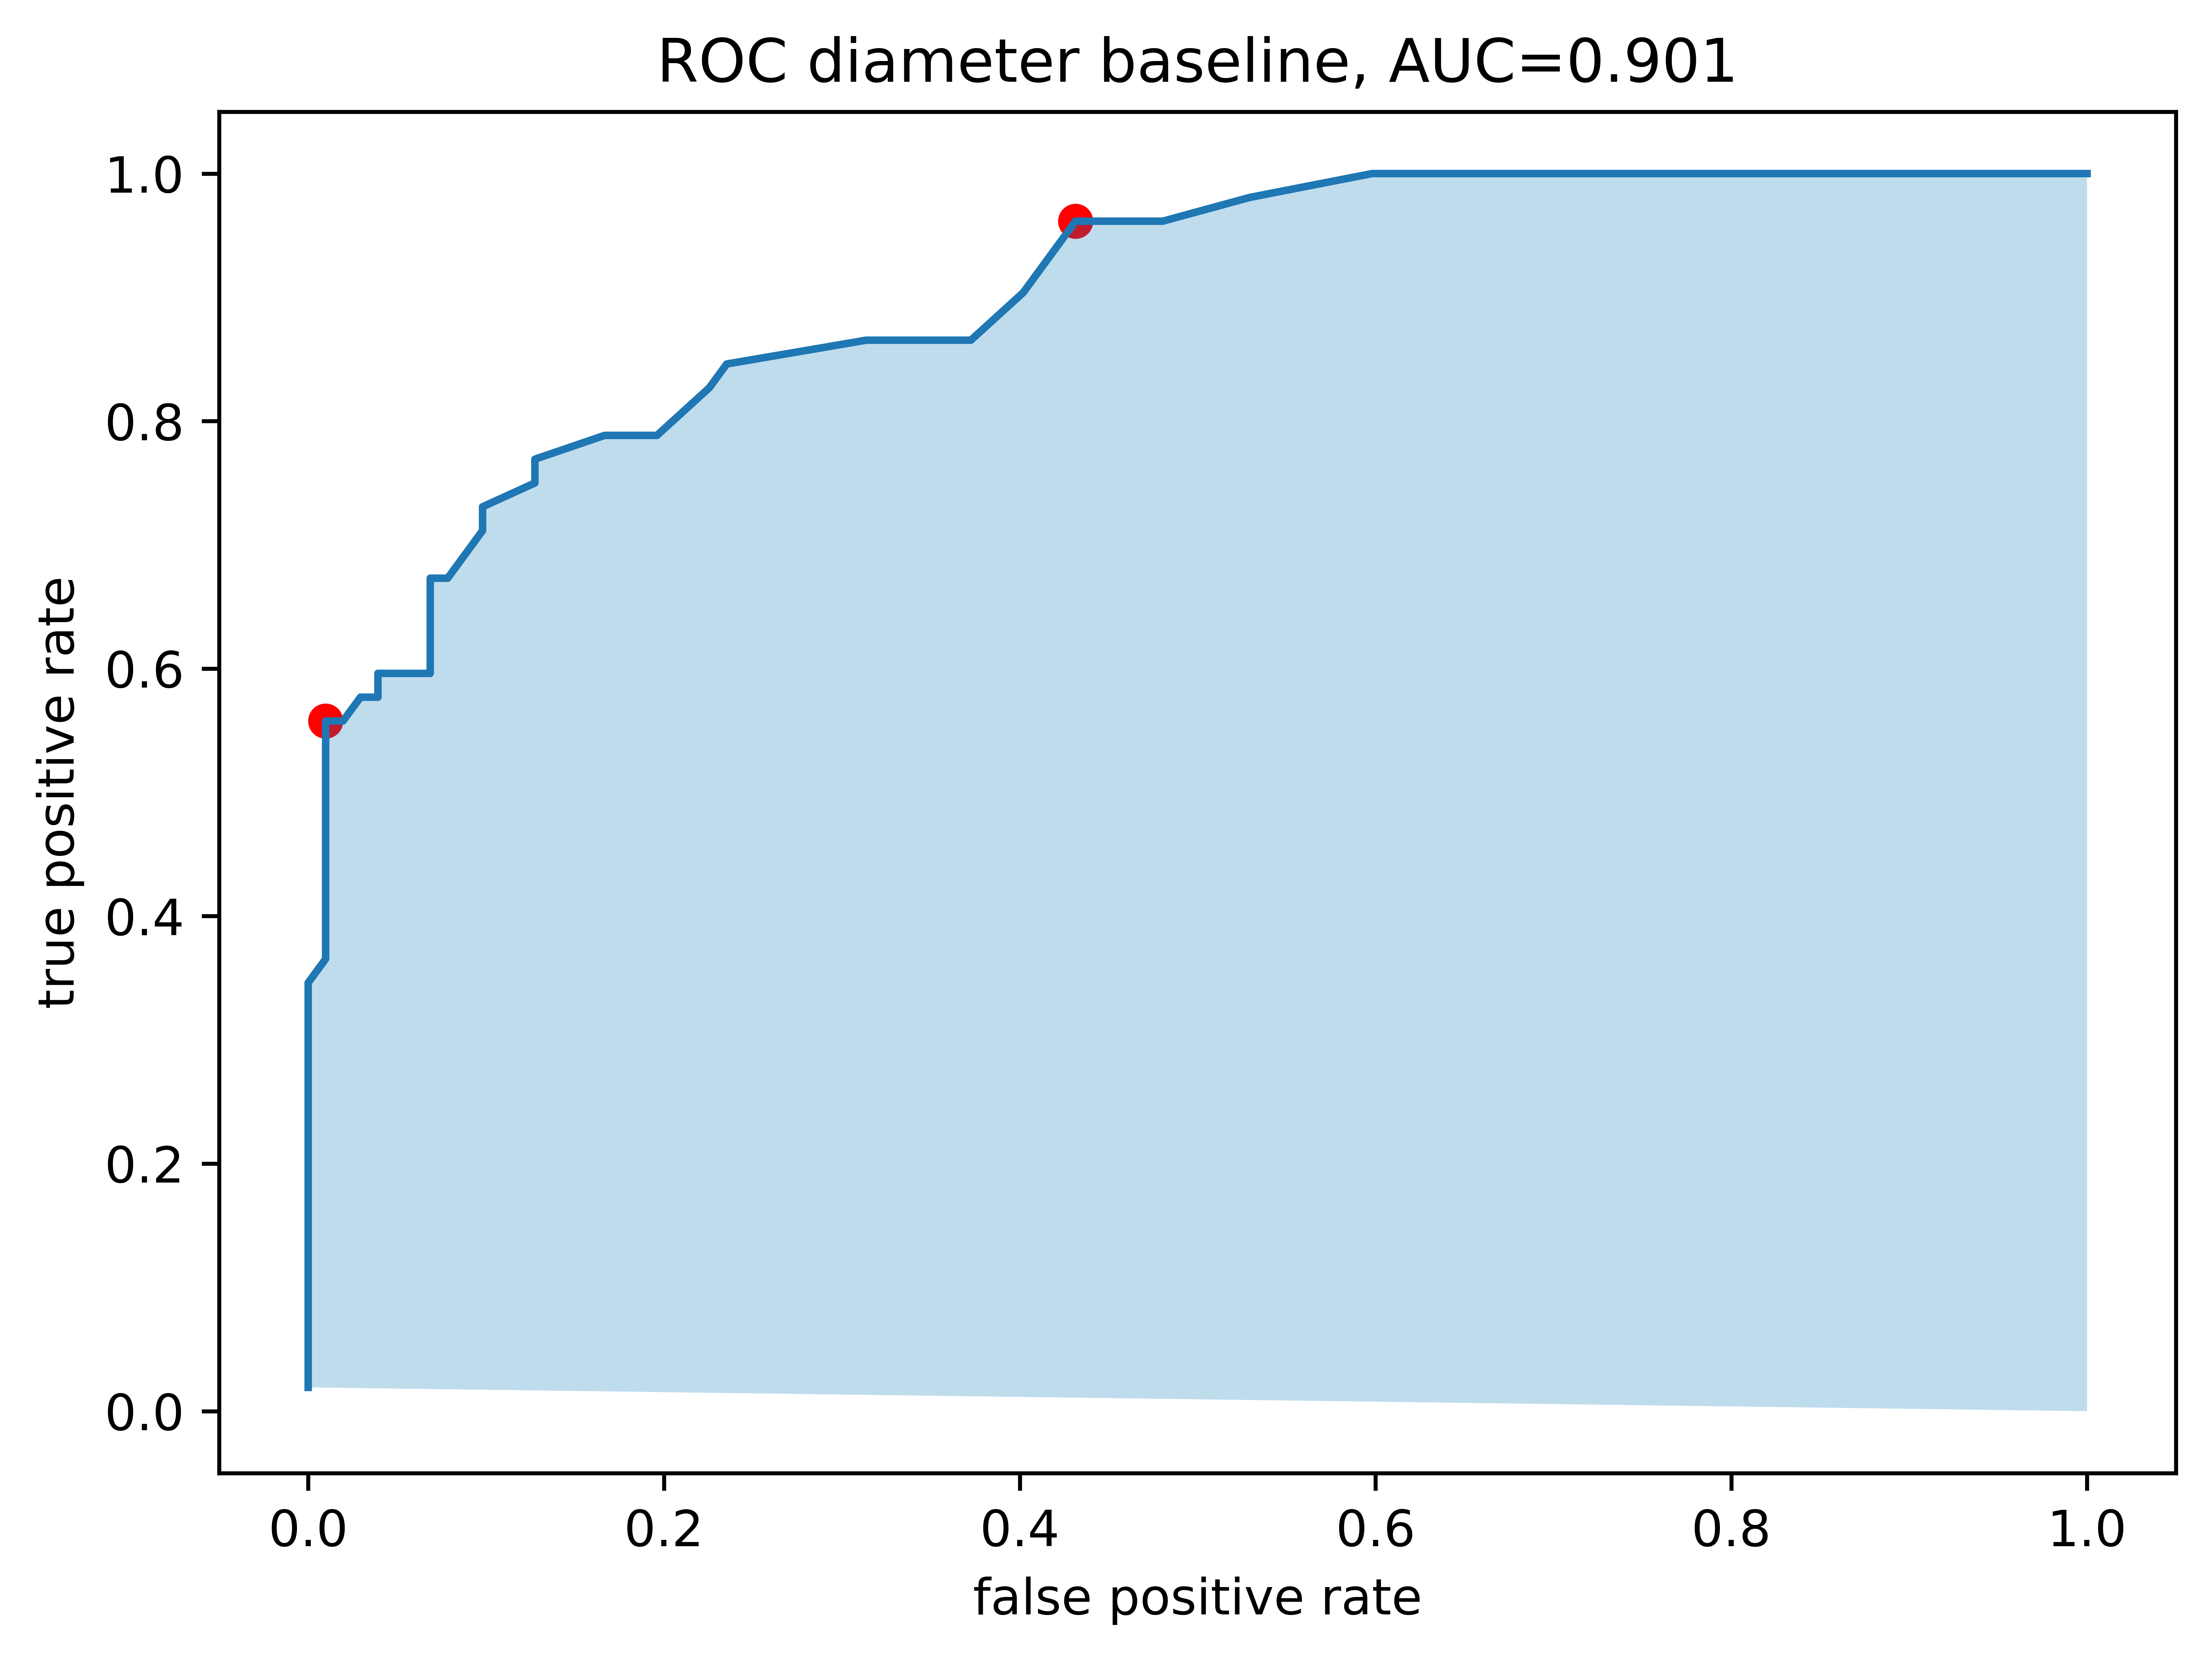

In [9]:
plt.figure(figsize=(7,5), dpi=1200)
for i in[62, 88]:
    plt.scatter(fp_diam[i], tp_diam[i], color='red')
    print(f'diam: {round(threshold[i].item(), 2)}, x:{round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}')
plt.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
plt.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_dim:.3f}')
plt.title(f'ROC diameter baseline, AUC={auc_dim:.3f}')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.savefig('imgs/roc_diameter_baseline.png')

In [10]:
model = model1.LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('trained_models/cls_2021-10-28_14.02.55_nodule-nonnodule.best.state')
model.load_state_dict(sd['model_state'])
model.to(device)
model.eval();

In [11]:
ds = dsets1.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=0)

2021-10-29 10:51:47,860 INFO     pid:21808 dsets1:280:__init__ <dsets1.MalignantLunaDataset object at 0x0000023992374A60>: 51583 validation samples, 51429 neg, 154 pos, unbalanced ratio


In [12]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

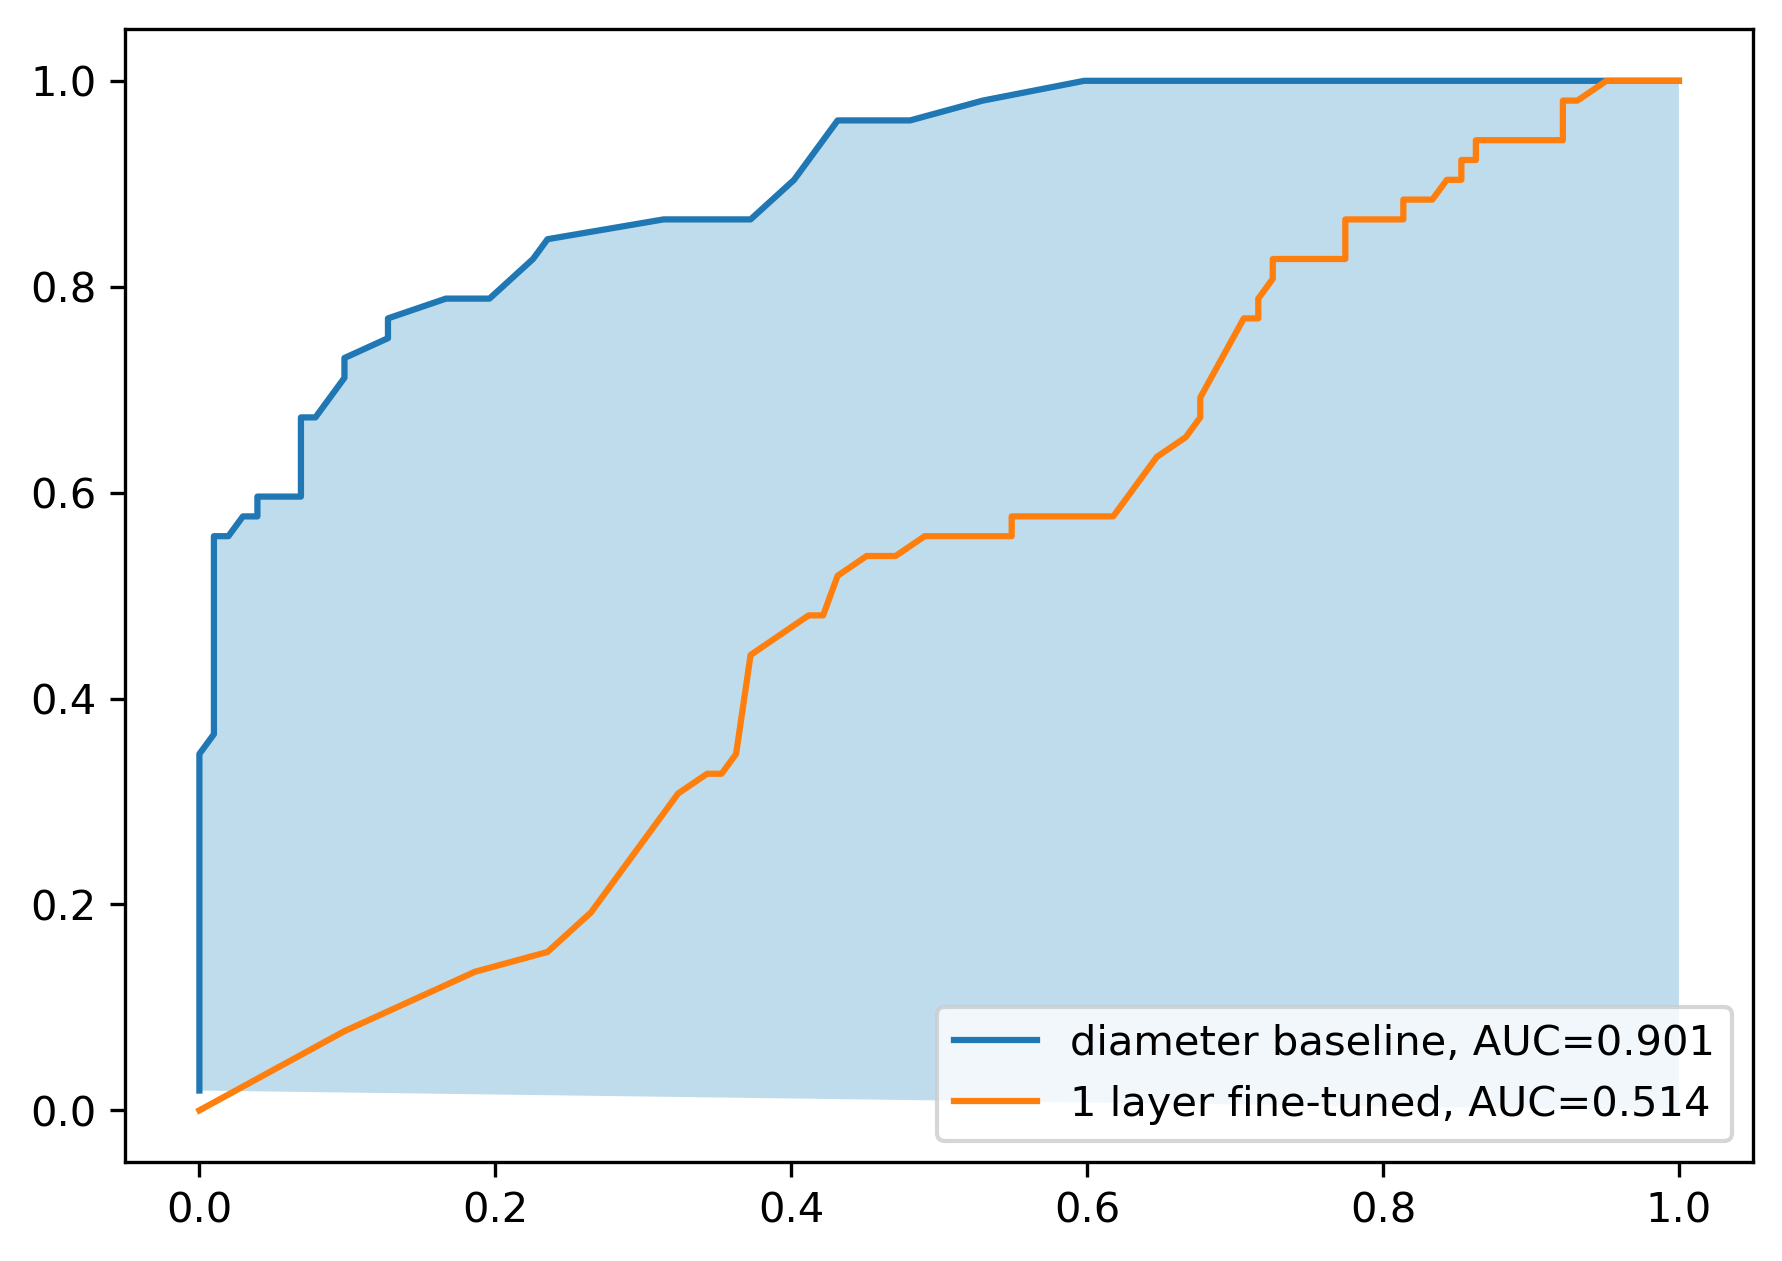

In [15]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben
fp_finetune_diff = fp_finetune[1:]-fp_finetune[:-1]
tp_finetune_avg  = (tp_finetune[1:]+tp_finetune[:-1])/2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

plt.figure(figsize=(7,5), dpi=300)
plt.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
plt.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_dim:.3f}')
plt.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
plt.legend()
plt.savefig('imgs/roc_finetune.png')